In [4]:
pip install --user --upgrade plotly

     |████████████████████████████████| 7.3MB 569kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --user jupyterlab==1.2 "ipywidgets==7.5"

     |████████████████████████████████| 6.4MB 533kB/s eta 0:00:01
     |████████████████████████████████| 122kB 61.3MB/s eta 0:00:01
ERROR: witwidget-gpu 1.5.0 requires tensorflow-gpu>=1.12.0, which is not installed.
ERROR: witwidget-gpu 1.5.0 requires tensorflow-serving-api-gpu>=1.12.0, which is not installed.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


# Google Analytics Customer Revenue Prediction

- The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.

- In this case study, we analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue per customer. Hopefully, the outcome will be more actionable operational changes and a better use of marketing budgets for those companies who choose to use data analysis on top of GA data.

## Evaluation

Submissions are scored on the root mean squared error. RMSE is defined as:

$\begin{align}\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2},\end{align}$

where y hat is the natural log of the predicted revenue for a customer and y is the natural log of the actual summed revenue value plus one.

<h3>About the dataset:</h3>

We are given two datasets - <b>train.csv</b> and <b>test.csv</b>

Each row in the datasets is one visit to the store. We are predicting the natural log of the sum of all transactions per user.

The data fields in the given files are

- fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
- channelGrouping - The channel via which the user came to the Store.
- date - The date on which the user visited the Store.
- device - The specifications for the device used to access the Store.
- geoNetwork - This section contains information about the geography of the user.
- sessionId - A unique identifier for this visit to the store.
- socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
- totals - This section contains aggregate values across the session.
- trafficSource - This section contains information about the Traffic Source from which the session originated.
- visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
- visitNumber - The session number for this user. If this is the first session, then this is set to 1.
- visitStartTime - The timestamp (expressed as POSIX time).
- Also it is important to note that some of the fields are in json format.

### What am I predicting?

- In the Kaggle competition, we have to take all the unique fullVisitorId's from the test dataset and predict the <b>Total Revenue </b> for each full visitor ID for their future transactions of 1st December 2018 - 31st January 2019.
-  Due to the formatting of fullVisitorId, we must load the Id's as strings in order for all Id's to be properly unique!
- Since We'ew not doing this competition as a kaggle competition, we will do all of our predictions on the test_v2.csv data using train_v2.csv as training data.

### Problem Trnasformation

- We transform this problem into a non-time series regression problem. This is because we have to predict for each user the estimated revenue that the user is likely to generate. And since a user who visits once may not visit again, we will solve this as a normal - regression type problem.

### Constraints

- For this problem, there are no constraints as such. The results of this problem will help GStore marketing team make better decisions when it comes to marketing practices. However, wrong information can lead to mismanagement of money allocation in marketing practices.

More about the problem here : https://www.kaggle.com/c/ga-customer-revenue-prediction/data

In [2]:
#https://pypi.org/project/plotly/
#plotly provides amazing visualizations - better than matplotlib!(another alternative is bokeh but plotly is better)
import pandas as pd
import dask.dataframe as dd
import numpy as np 
import json
#import bq_helper
from pandas.io.json import json_normalize
import seaborn as sns 
import matplotlib.pyplot as plt 
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
from plotly import subplots
import sys
import csv
import os
import json
from pandas.io.json import json_normalize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack,vstack
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import sklearn
import plotly.io as pio
pio.renderers.default='notebook'
init_notebook_mode(connected=True)


In [111]:
#import os
#os.rename('train_v2.csv', 'trainset.csv')
#os.rename('test_v2.csv','testset.csv')

In [2]:
#incase you receive an overflow error while loading the csv files, run this cell
#otherwise, skip this cell
'''maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)'''

In [3]:
#Loading the test and train datasets
df_train = pd.read_csv('trainset.csv',nrows=10)
df_test = pd.read_csv('testset.csv',nrows = 10)

In [4]:
df_train.head(2)

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",3162355547410993243,"{""continent"": ""Europe"", ""subContinent"": ""Weste...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508198450,1,1508198450
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8934116514970143966,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""referralPath"": ""/a/google.com/transportation...",1508176307,6,1508176307


In [5]:
df_test.head(2)

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'APAC'}]",20180511,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",7460955084541987166,"{""continent"": ""Asia"", ""subContinent"": ""Souther...","[{'hitNumber': '1', 'time': '0', 'hour': '21',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""4"", ""pageviews"": ""3"",...","{""referralPath"": ""(not set)"", ""campaign"": ""(no...",1526099341,2,1526099341
1,Direct,"[{'index': '4', 'value': 'North America'}]",20180511,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",460252456180441002,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '11',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""4"", ""pageviews"": ""3"",...","{""referralPath"": ""(not set)"", ""campaign"": ""(no...",1526064483,166,1526064483


- we see that quite a few of these columns have nested values, namely custom dimensions, device, geoNetwork, hits

In [6]:
#Exploring one value under the hit column
df_train.iloc[0,6]

"[{'hitNumber': '1', 'time': '0', 'hour': '17', 'minute': '0', 'isInteraction': True, 'isEntrance': True, 'isExit': True, 'referer': 'https://www.google.co.uk/search?q=water+bottle&ie=utf-8&num=100&oe=utf-8&hl=en&gl=GB&uule=w+CAIQIFISCamRx0IRO1oCEXoliDJDoPjE&glp=1&gws_rd=cr&fg=1', 'page': {'pagePath': '/google+redesign/bags/water+bottles+and+tumblers', 'hostname': 'shop.googlemerchandisestore.com', 'pageTitle': 'Water Bottles & Tumblers | Drinkware | Google Merchandise Store', 'pagePathLevel1': '/google+redesign/', 'pagePathLevel2': '/bags/', 'pagePathLevel3': '/water+bottles+and+tumblers', 'pagePathLevel4': ''}, 'transaction': {'currencyCode': 'USD'}, 'item': {'currencyCode': 'USD'}, 'appInfo': {'screenName': 'shop.googlemerchandisestore.com/google+redesign/bags/water+bottles+and+tumblers', 'landingScreenName': 'shop.googlemerchandisestore.com/google+redesign/bags/water+bottles+and+tumblers', 'exitScreenName': 'shop.googlemerchandisestore.com/google+redesign/bags/water+bottles+and+tum

In [7]:
# exploring one value under the totals column
df_train.iloc[0,8]

'{"visits": "1", "hits": "1", "pageviews": "1", "bounces": "1", "newVisits": "1", "sessionQualityDim": "1"}'

In [8]:
df_train.iloc[0,9]

'{"campaign": "(not set)", "source": "google", "medium": "organic", "keyword": "water bottle", "adwordsClickInfo": {"criteriaParameters": "not available in demo dataset"}}'

In [9]:
df_train.iloc[0,5]

'{"continent": "Europe", "subContinent": "Western Europe", "country": "Germany", "region": "not available in demo dataset", "metro": "not available in demo dataset", "city": "not available in demo dataset", "cityId": "not available in demo dataset", "networkDomain": "(not set)", "latitude": "not available in demo dataset", "longitude": "not available in demo dataset", "networkLocation": "not available in demo dataset"}'

In [10]:
df_train.iloc[0,3]

'{"browser": "Firefox", "browserVersion": "not available in demo dataset", "browserSize": "not available in demo dataset", "operatingSystem": "Windows", "operatingSystemVersion": "not available in demo dataset", "isMobile": false, "mobileDeviceBranding": "not available in demo dataset", "mobileDeviceModel": "not available in demo dataset", "mobileInputSelector": "not available in demo dataset", "mobileDeviceInfo": "not available in demo dataset", "mobileDeviceMarketingName": "not available in demo dataset", "flashVersion": "not available in demo dataset", "language": "not available in demo dataset", "screenColors": "not available in demo dataset", "screenResolution": "not available in demo dataset", "deviceCategory": "desktop"}'

- When exchanging data between a browser and a server, the data can only be text.
- JSON is text, and we can convert any JavaScript object into JSON, and send JSON to the server.
- The same goes for receiving from the server. We recieve all data in JSON text, and it is interpreted by the browser to dispaly the webpage.
- The nested values that we see are called json blobs, they are values received in JSON format from the browser.

### Expanding the columns that have JSON blobs in them

- We will flatten all the columns with JSON feilds in them except hits, as hits as multiple nested JSON blobs.
- Hits is basically a record for every activity of the user per hit. Many values of hits are redundant and repeated in other columns. We will eventually delete 'hits' from both train and test data.
- Value from customDimensions is repeated in geoNetwork. Hence we will also delete the column 'customDimensions'

In [35]:
#Source : https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields
def load_df(csv_path = 'trainset.csv',nrows = None):
    """We first note all the columns that have JSON blobs and we want to expand in a list 'JSON_Columns'
    We then specify converters for converting values in certain columns. json. load is the important method to note here. It reads the string from the file, parses the JSON data, populates a Python dict with the data and returns it back to the dataframe. 
    Then for every column in JSON_columns, we noralize the semi structured JSON data into a flat table.
    We then write our column names as column.subcolumn eg: totals.transactionRevenue"""
    JSON_Columns = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path , converters = {column:json.loads for column in JSON_Columns},dtype={'fullVisitorId': 'str'},nrows = nrows)
    
    for column in JSON_Columns:
        column_df = json_normalize(df[column])
        column_df.columns = ["{}.{}".format(column, subcolumn) for subcolumn in column_df.columns]
        df = df.drop(column, axis=1).merge(column_df, right_index=True, left_index=True)
    print("Loaded {}. Shape: {}".format(os.path.basename(csv_path), df.shape))
    return df

In [36]:
help(load_df)

Help on function load_df in module __main__:

load_df(csv_path='trainset.csv', nrows=None)
    We first note all the columns that have JSON blobs and we want to expand in a list 'JSON_Columns'
    We then specify converters for converting values in certain columns. json. load is the important method to note here. It reads the string from the file, parses the JSON data, populates a Python dict with the data and returns it back to the dataframe. 
    Then for every column in JSON_columns, we noralize the semi structured JSON data into a flat table.
    We then write our column names as column.subcolumn eg: totals.transactionRevenue



In [12]:
df_train = load_df(csv_path = 'trainset.csv')
df_test = load_df(csv_path = 'testset.csv')

Loaded trainset.csv. Shape: (1708337, 60)
Loaded testset.csv. Shape: (401589, 59)


In [13]:
#as explained above, we will be deleting the columns 
del df_train['customDimensions']
del df_test['customDimensions']

In [14]:
# we will delete column hits as well
del df_train['hits']
del df_test['hits']

In [15]:
df_train

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,water bottle,organic,NaN,google
1,Referral,20171016,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,20171016,7992466427990357681,Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,NaN,(none),NaN,(direct)
3,Organic Search,20171016,9075655783635761930,Not Socially Engaged,1508169851,1,1508169851,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
4,Organic Search,20171016,6960673291025684308,Not Socially Engaged,1508190552,1,1508190552,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1708332,Social,20170104,5123779100307500332,Not Socially Engaged,1483554750,1,1483554750,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/yt/about/,youtube.com
1708333,Social,20170104,7231728964973959842,Not Socially Engaged,1483543798,1,1483543798,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/yt/about/,youtube.com
1708334,Social,20170104,5744576632396406899,Not Socially Engaged,1483526434,1,1483526434,Android Webview,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/yt/about/ko/,youtube.com
1708335,Social,20170104,2709355455991750775,Not Socially Engaged,1483592857,1,1483592864,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/l.php,facebook.com


In [16]:
df_test

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,...,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20180511,7460955084541987166,Not Socially Engaged,1526099341,2,1526099341,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,(not set),google
1,Direct,20180511,460252456180441002,Not Socially Engaged,1526064483,166,1526064483,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),True,(not set),(none),(not set),(direct)
2,Organic Search,20180511,3461808543879602873,Not Socially Engaged,1526067157,2,1526067157,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,(not set),google
3,Direct,20180511,975129477712150630,Not Socially Engaged,1526107551,4,1526107551,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),True,(not set),(none),(not set),(direct)
4,Organic Search,20180511,8381672768065729990,Not Socially Engaged,1526060254,1,1526060254,Internet Explorer,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,(not set),google
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401584,Organic Search,20180907,6701149525099562370,Not Socially Engaged,1536353803,1,1536353803,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,(not set),google
401585,Organic Search,20180907,6154541330147351453,Not Socially Engaged,1536388075,1,1536388075,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,(not set),google
401586,Organic Search,20180907,6013469762773705448,Not Socially Engaged,1536351791,3,1536351791,Firefox,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,(not set),google
401587,Organic Search,20180907,4565378823441900999,Not Socially Engaged,1536340217,1,1536340217,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,(not set),google


In [17]:
# saving flattened data
df_train.to_csv("train-flattened.csv", index=False)
df_test.to_csv('test-flattened.csv', index = False)

## Exploratory Data Analysis

In [3]:
df_train = pd.read_csv('train-flattened.csv')
df_test = pd.read_csv('test-flattened.csv')

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (2,52) have mixed types. Specify dtype option on import or set low_memory=False.

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



In [4]:
#we will perform EDA and see the columns that are worth keeping.
#df['Col1'].cat.categories
# A good machine learning model is one where there is variability between features and 
# the prediction variable, and less between variables themselves.
# hence, in out analysis, we will concentrate only on the feature and totals.transactionRevenue


### Transaction revenue for every visitor ID

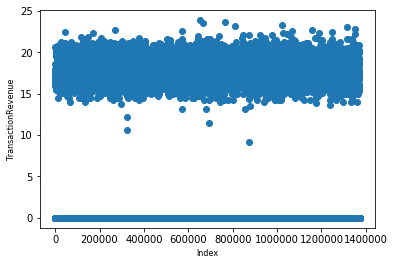

In [5]:
df_train['totals.transactionRevenue'].fillna(0,inplace=True)
df_test['totals.transactionRevenue'].fillna(0,inplace = True)
rev_id = df_train.groupby('fullVisitorId')['totals.transactionRevenue'].sum()
lrn = len(rev_id)

plt.scatter(range(rev_id.shape[0]),np.log1p(df_train['totals.transactionRevenue'][0:lrn]))
plt.xlabel('Index', fontsize=8)
plt.ylabel('TransactionRevenue', fontsize=8)
plt.show()

- From the scatter plot, it shows that that there is a disparity between customers that spend and customers that don't.

## Channel grouping Insights

- Below, we see the variance of Channel grouping with the sum and mean of total transaction value per channel.

In [81]:
#https://seaborn.pydata.org/examples/horizontal_barplot.html
#https://seaborn.pydata.org/generated/seaborn.barplot.html
#https://stackoverflow.com/questions/43562577/horizontal-barplot-in-seaborn-using-dataframe
def horizontal_bar_chart(y1, x1, y2, x2, y3, x3, data):
    f, axes = plt.subplots(1,3,figsize=(18, 6))

    sns.set(style="whitegrid")
    sns.set_color_codes("pastel")
    sns.barplot(y=y1, x=x1, data=data,
            label="Total", ax=axes[0])

    sns.set(style="whitegrid")
    sns.set_color_codes("pastel")
    sns.barplot(y=y2, x=x2, data=data,
            label="Total", ax=axes[1])

    sns.set(style="whitegrid")
    sns.set_color_codes("pastel")
    sns.barplot(y=y3, x=x3, data=data,
            label="Total", ax=axes[2])

    plt.tight_layout()

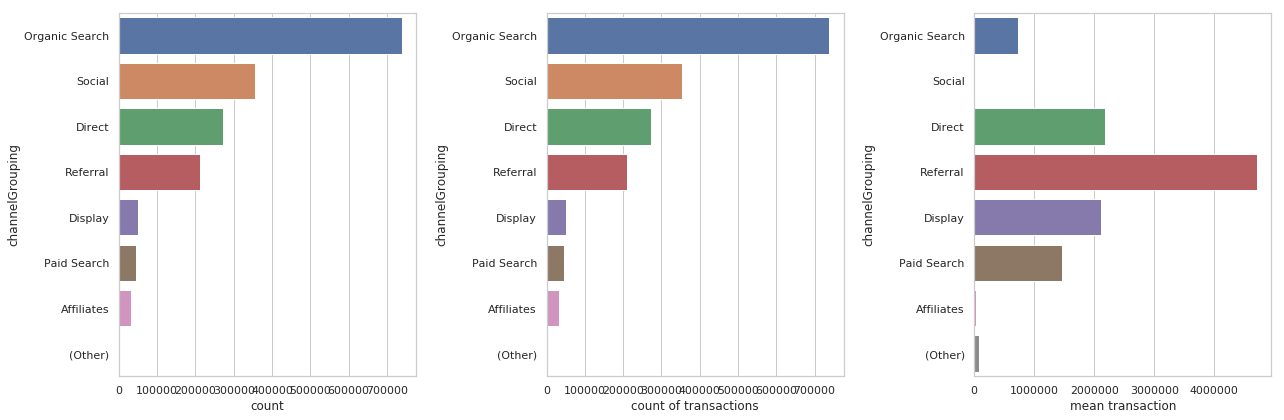

In [84]:
data = df_train.groupby("channelGrouping")["totals.transactionRevenue"].agg(['size', 'count', 'mean'])
data.columns = ["count", "count of transactions", "mean transaction"]
data.reset_index(inplace=True)
data = data.sort_values(by="count", ascending=False)

horizontal_bar_chart("channelGrouping", "count", "channelGrouping", "count of transactions", "channelGrouping", "mean transaction", data.head(10))

### Deleting Columns with less than 3 unique values as these do not contribute with significant variance

- we will dellete columns that have less that three unique values as these would not offer much variability for prediction


In [8]:
### Deleting Columns with less than 3 unique values as these do not contribute with significant variance
# we will dellete columns that have less that three unique values as these would not offer much variability for prediction

#This function just finds the columns that have less than 3 unique values and strores them in a list to be deleted
list_cols_del = []
for cols in df_train.columns.values:
    if len(df_train[cols].unique())<3:
        list_cols_del.append(cols)
        
for cols in list_cols_del:
    del(df_train[cols])

list_cols_test = []    

for cols in df_test.columns.values:
    if len(df_test[cols].unique())<3:
        list_cols_test.append(cols)
        
for cols in list_cols_test:
    del(df_test[cols])

## Visit number Analysis

#### Box plot to show number of times GStore was visited

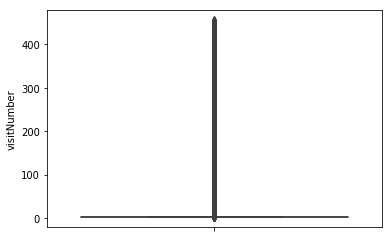

In [9]:
sns.boxplot(y="visitNumber", data =df_train)
plt.show()

- Since the number of times a person visits a website, the more likely he is to buy something

In [10]:
# Let's see the percentile values
for i in range(0,100,10):
    var = df_train["visitNumber"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 1
10 percentile value is 1
20 percentile value is 1
30 percentile value is 1
40 percentile value is 1
50 percentile value is 1
60 percentile value is 1
70 percentile value is 1
80 percentile value is 2
90 percentile value is 3
100 percentile value is  457


In [11]:
for i in range(90,100):
    var = df_train["visitNumber"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 3
91 percentile value is 3
92 percentile value is 4
93 percentile value is 4
94 percentile value is 5
95 percentile value is 6
96 percentile value is 7
97 percentile value is 8
98 percentile value is 12
99 percentile value is 22
100 percentile value is  457


In [12]:
for i in np.arange(99,100,0.1):
    var = df_train["visitNumber"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

99.0 percentile value is 22
99.1 percentile value is 24
99.19999999999999 percentile value is 27
99.29999999999998 percentile value is 30
99.39999999999998 percentile value is 35
99.49999999999997 percentile value is 42
99.59999999999997 percentile value is 53
99.69999999999996 percentile value is 69
99.79999999999995 percentile value is 98
99.89999999999995 percentile value is 145
100 percentile value is  457


- From the data, it looks like there are some shopaholics that visit the website a lot

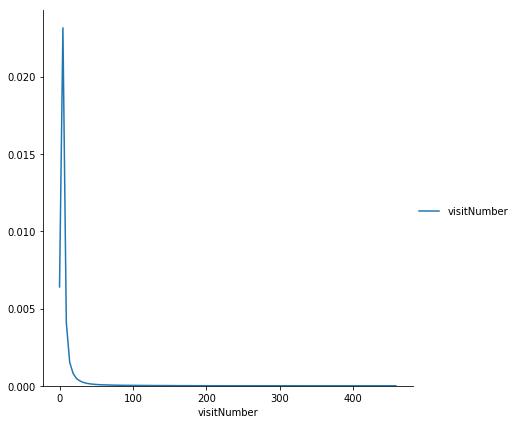

In [13]:
sns.FacetGrid(df_train,height=6).map(sns.kdeplot,"visitNumber").add_legend();
plt.show();

- the graph above looks like it can be converted to a log-normal cirve. Let's use the log curve to see if this is true

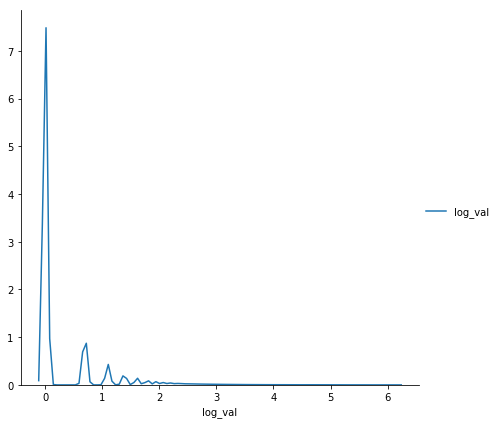

In [14]:
import math
df_train['log_val']=[math.log(i) for i in df_train['visitNumber'].values]

sns.FacetGrid(df_train,height=6).map(sns.kdeplot,"log_val").add_legend();
plt.show();

- Turns out that visit number does not follow the normal curve.

In [15]:
del(df_train['log_val'])

### Lets see in tabular form how much percent of feilds are missing 

- first, it's pretty evident form observing the dataset that a lot of values are missing.Sow e see how many values

In [16]:
percent_missing = df_train.isnull().sum() * 100 / len(df_train)
missing_value_df = pd.DataFrame({'column_name': df_train.columns,'percent_missing': percent_missing})

In [17]:
missing_value_df

,column_name,percent_missing
channelGrouping,channelGrouping,0.000000
date,date,0.000000
fullVisitorId,fullVisitorId,0.000000
visitId,visitId,0.000000
visitNumber,visitNumber,0.000000
visitStartTime,visitStartTime,0.000000
device.browser,device.browser,0.000000
device.deviceCategory,device.deviceCategory,0.000000
device.operatingSystem,device.operatingSystem,0.000000
geoNetwork.city,geoNetwork.city,0.000000


- feilds with high missing values in the dataset are candidates to be dropped, since they do not add a lot of variability and imputing values will change the behviour of the dataset. We will continue data exploration with these values for now. We will delete many columns later

## Analysis of device browser, category and Operating System wrt Transaction Revenue

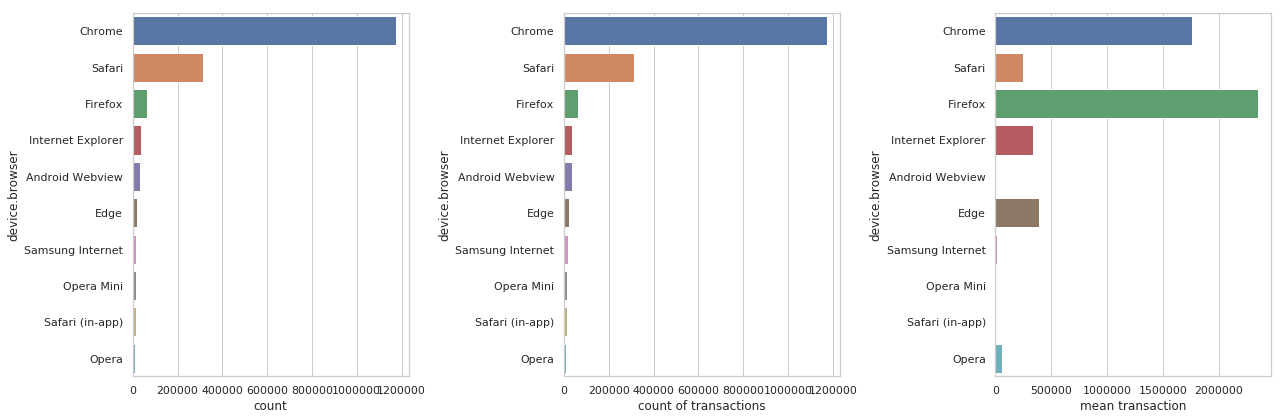

In [85]:
data = df_train.groupby("device.browser")["totals.transactionRevenue"].agg(['size', 'count', 'mean'])
data.columns = ["count", "count of transactions", "mean transaction"]
data.reset_index(inplace=True)
data = data.sort_values(by="count", ascending=False)

horizontal_bar_chart("device.browser", "count", "device.browser", "count of transactions", "device.browser", "mean transaction", data.head(10))

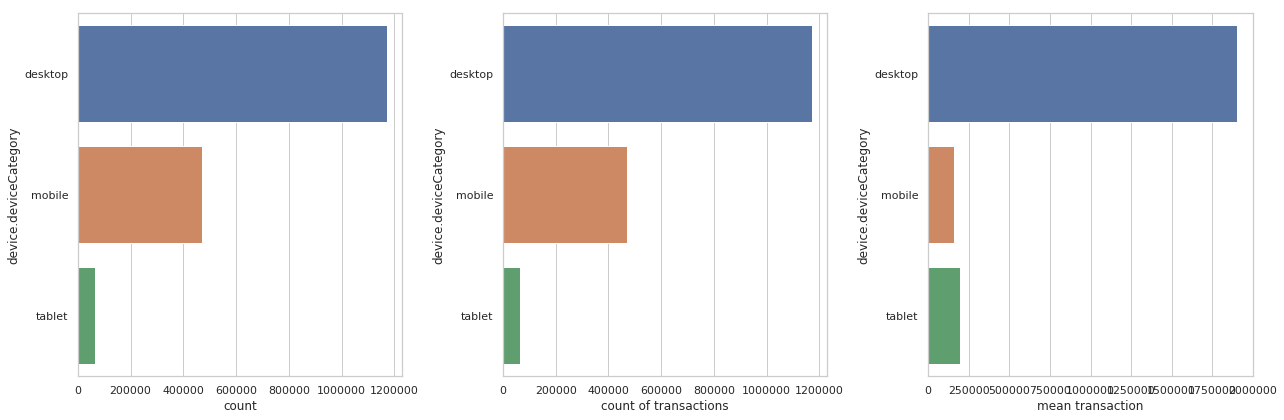

In [86]:
data = df_train.groupby("device.deviceCategory")["totals.transactionRevenue"].agg(['size', 'count', 'mean'])
data.columns = ["count", "count of transactions", "mean transaction"]
data.reset_index(inplace=True)
data = data.sort_values(by="count", ascending=False)

horizontal_bar_chart("device.deviceCategory", "count", "device.deviceCategory", "count of transactions", "device.deviceCategory", "mean transaction", data.head(10))

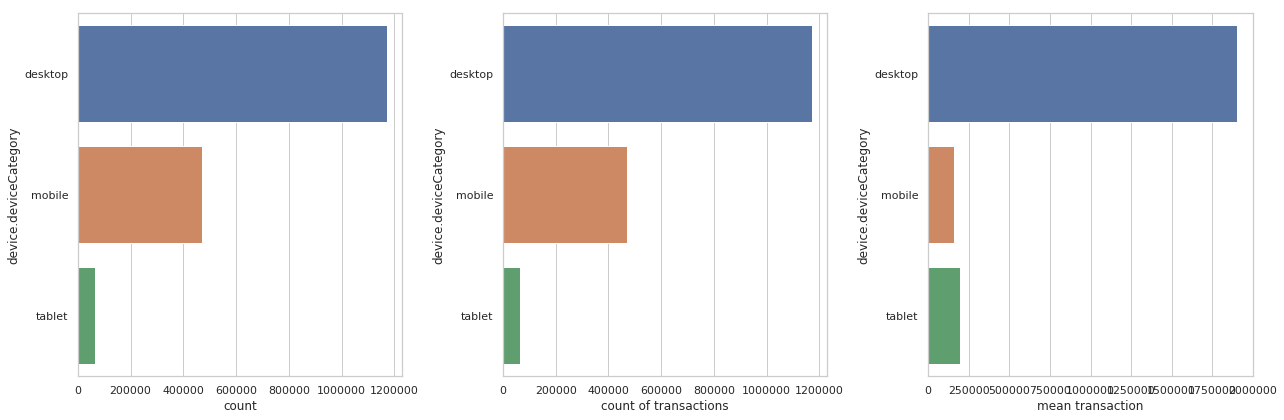

In [87]:
data = df_train.groupby("device.deviceCategory")["totals.transactionRevenue"].agg(['size', 'count', 'mean'])
data.columns = ["count", "count of transactions", "mean transaction"]
data.reset_index(inplace=True)
data = data.sort_values(by="count", ascending=False)

horizontal_bar_chart("device.deviceCategory", "count", "device.deviceCategory", "count of transactions", "device.deviceCategory", "mean transaction", data.head(10))

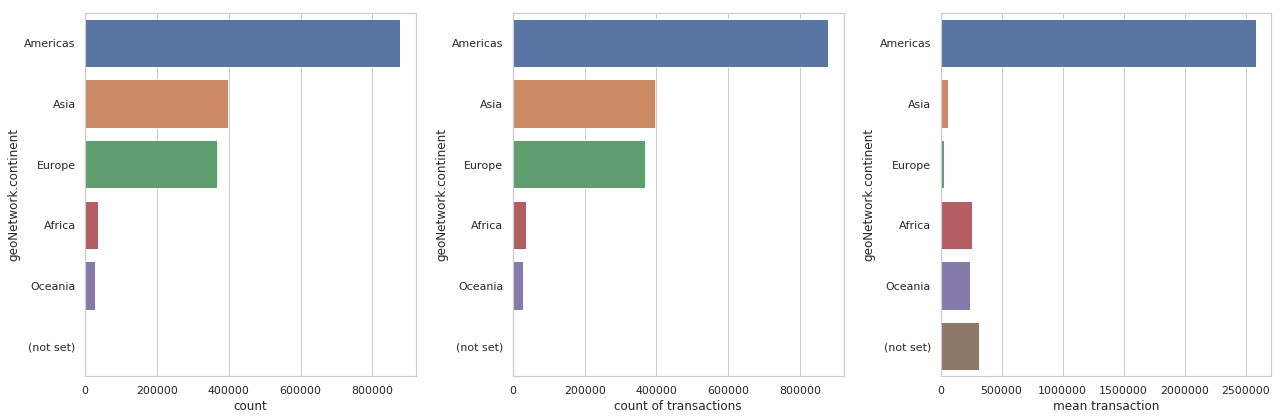

In [88]:
data = df_train.groupby("geoNetwork.continent")["totals.transactionRevenue"].agg(['size', 'count', 'mean'])
data.columns = ["count", "count of transactions", "mean transaction"]
data.reset_index(inplace=True)
data = data.sort_values(by="count", ascending=False)

horizontal_bar_chart("geoNetwork.continent", "count", "geoNetwork.continent", "count of transactions", "geoNetwork.continent", "mean transaction", data.head(10))

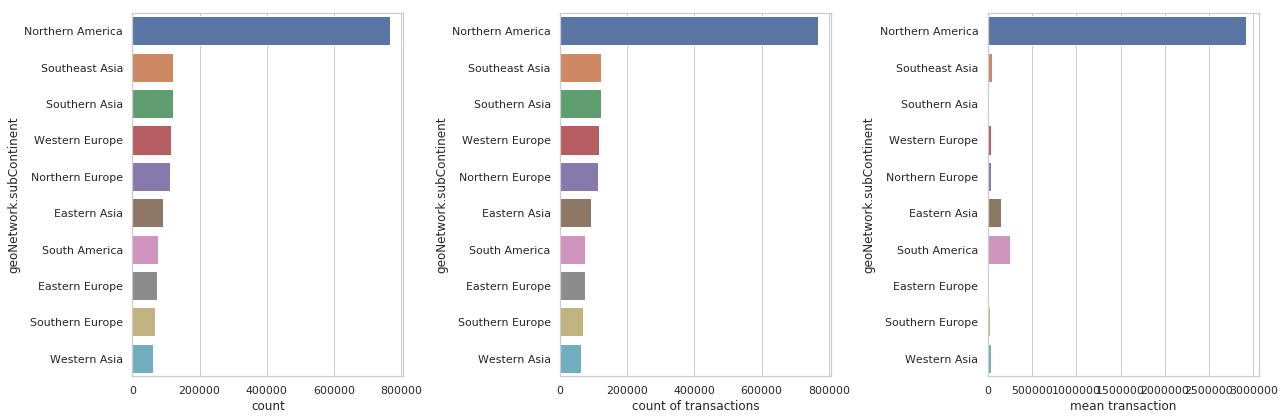

In [89]:
data = df_train.groupby("geoNetwork.subContinent")["totals.transactionRevenue"].agg(['size', 'count', 'mean'])
data.columns = ["count", "count of transactions", "mean transaction"]
data.reset_index(inplace=True)
data = data.sort_values(by="count", ascending=False)

horizontal_bar_chart("geoNetwork.subContinent", "count", "geoNetwork.subContinent", "count of transactions", "geoNetwork.subContinent", "mean transaction", data.head(10))

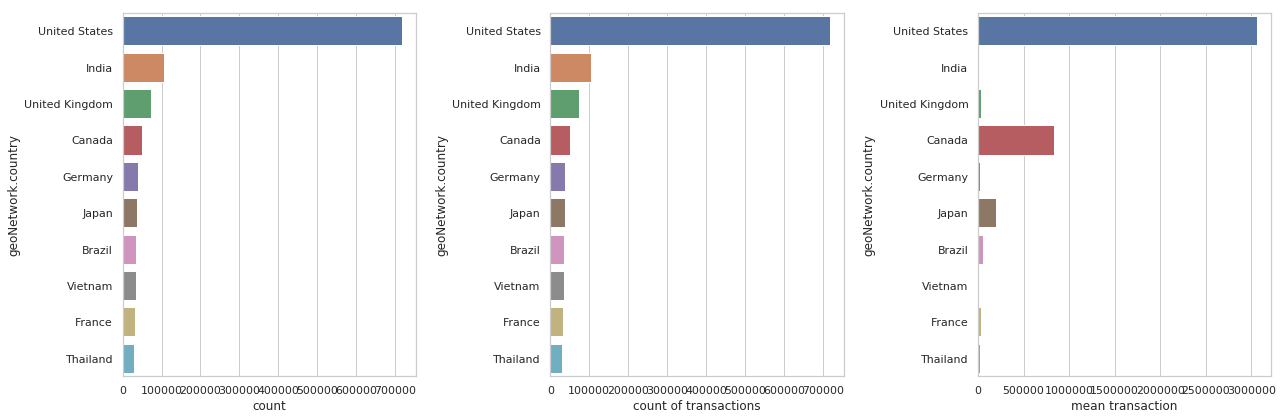

In [90]:
data = df_train.groupby("geoNetwork.country")["totals.transactionRevenue"].agg(['size', 'count', 'mean'])
data.columns = ["count", "count of transactions", "mean transaction"]
data.reset_index(inplace=True)
data = data.sort_values(by="count", ascending=False)

horizontal_bar_chart("geoNetwork.country", "count", "geoNetwork.country", "count of transactions", "geoNetwork.country", "mean transaction", data.head(10))


### Revenue by date

In [21]:
df_train['date'] = df_train['date'].astype(str)
df_train["date"] = df_train["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
df_train["date"] = pd.to_datetime(df_train["date"])

df_test['date'] = df_test['date'].astype(str)
df_test["date"] = df_test["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
df_test["date"] = pd.to_datetime(df_test["date"])

In [22]:
# the date is given in a continuous form. eg: 20180501
# we use the code above to seperate the date into normal form eg: 2018-05-01

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



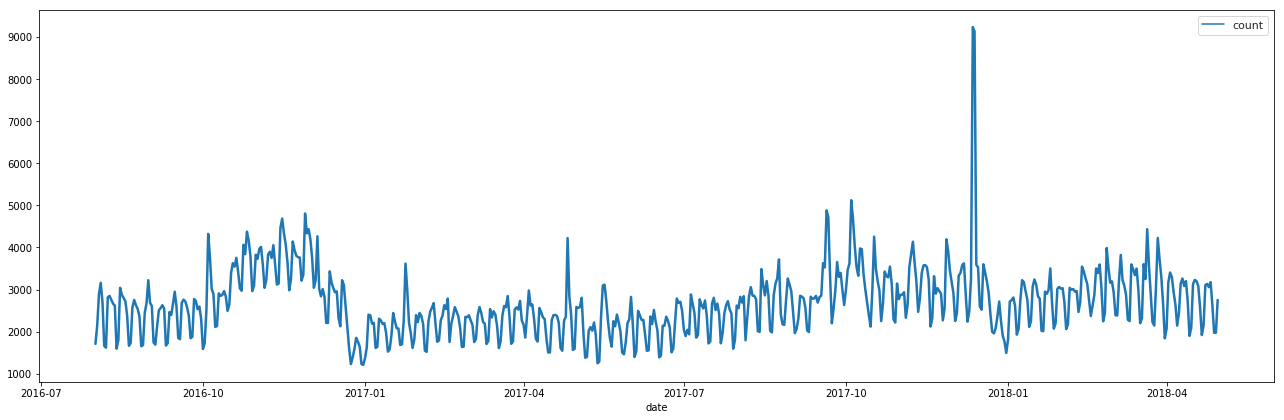

In [23]:
import seaborn as sns
tran_rev = df_train.groupby("date")['totals.transactionRevenue'].agg(['count'])
f, axes = plt.subplots(figsize=(18, 6))
sns.set(style="white")
sns.lineplot( data=tran_rev, palette="tab10", linewidth=2.5)
plt.tight_layout()

- Then trend of total revenue by date can be seen from the plot above. We see a sharp spike in december, maybe due to christmas and new year spending.


### Visual for Visits by country

In [24]:
#https://www.kaggle.com/arthurtok/generation-unemployed-interactive-plotly-visuals
temp = df_train['geoNetwork.country'].value_counts()
metricscale = [[0, 'rgb(102,194,165)'], [0.05, 'rgb(102,194,165)'], 
              [0.15, 'rgb(171,221,164)'], [0.2, 'rgb(230,245,152)'], 
              [0.25, 'rgb(255,255,191)'], [0.35, 'rgb(254,224,139)'], 
              [0.45, 'rgb(253,174,97)'], [0.55, 'rgb(213,62,79)'], [1.0, 'rgb(158,1,66)']]

data = [ dict(type = 'choropleth',autocolorscale = False,colorscale = metricscale,showscale = True,locations = temp.index,
        z = temp.values,locationmode = 'country names',text = temp.index,
        marker = dict(line = dict(color = 'rgb(250,250,225)', width = 0.5)),colorbar = dict(bgcolor= 'rgb(128,158,188)', tickprefix = '', 
            title = 'Rate'))]

layout = dict(
    height=500,
    title = 'Visits by Country',
    geo = dict(
        showframe = True,
        showocean = True,
        oceancolor = '#222',
        projection = dict(
        type = 'orthographic',
            rotation = dict(
                    lon = 60,
                    lat = 10),
        ),
        lonaxis =  dict(
                showgrid = False,
                gridcolor = 'rgb(102, 102, 102)'
            ),
        lataxis = dict(
                showgrid = False,
                gridcolor = 'rgb(102, 102, 102)'
                )
            ),
        )
fig = dict(data=data, layout=layout)
iplot(fig)

# Cleaning and Feature Engineering

### Deleting Columns with less than 3 unique values as these do not contribute with significant variance
 

- we will dellete columns that have less that three unique values as these would not offer much variability for prediction


In [25]:
#This function just finds the columns that have less than 3 unique values and strores them in a list to be deleted
list_cols_del = []
for cols in df_train.columns.values:
    if len(df_train[cols].unique())<3:
        list_cols_del.append(cols)
        
for cols in list_cols_del:
    del(df_train[cols])

list_cols_test = []    

for cols in df_test.columns.values:
    if len(df_test[cols].unique())<3:
        list_cols_test.append(cols)
        
for cols in list_cols_test:
    del(df_test[cols])

### Adding some more features based on date and user vitsit, hit, time page view and sum count

In [26]:
df_train
df_test

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.operatingSystem,geoNetwork.city,...,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,2018-05-11,7460955084541987166,1526099341,2,1526099341,Chrome,mobile,Android,(not set),...,(not set),NaN,NaN,NaN,NaN,(not set),(not provided),organic,(not set),google
1,Direct,2018-05-11,460252456180441002,1526064483,166,1526064483,Chrome,desktop,Macintosh,San Francisco,...,(not set),NaN,NaN,NaN,NaN,(not set),(not set),(none),(not set),(direct)
2,Organic Search,2018-05-11,3461808543879602873,1526067157,2,1526067157,Chrome,desktop,Chrome OS,not available in demo dataset,...,(not set),NaN,NaN,NaN,NaN,(not set),(not provided),organic,(not set),google
3,Direct,2018-05-11,975129477712150630,1526107551,4,1526107551,Chrome,mobile,iOS,Houston,...,(not set),NaN,NaN,NaN,NaN,(not set),(not set),(none),(not set),(direct)
4,Organic Search,2018-05-11,8381672768065729990,1526060254,1,1526060254,Internet Explorer,tablet,Windows,Irvine,...,(not set),NaN,NaN,NaN,NaN,(not set),(not provided),organic,(not set),google
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401584,Organic Search,2018-09-07,6701149525099562370,1536353803,1,1536353803,Chrome,mobile,Android,not available in demo dataset,...,(not set),NaN,NaN,NaN,NaN,(not set),(not provided),organic,(not set),google
401585,Organic Search,2018-09-07,6154541330147351453,1536388075,1,1536388075,Chrome,desktop,Windows,not available in demo dataset,...,(not set),NaN,NaN,NaN,NaN,(not set),(not provided),organic,(not set),google
401586,Organic Search,2018-09-07,6013469762773705448,1536351791,3,1536351791,Firefox,desktop,Windows,not available in demo dataset,...,(not set),NaN,NaN,NaN,NaN,(not set),(not provided),organic,(not set),google
401587,Organic Search,2018-09-07,4565378823441900999,1536340217,1,1536340217,Chrome,desktop,Chrome OS,not available in demo dataset,...,(not set),NaN,NaN,NaN,NaN,(not set),(not provided),organic,(not set),google


In [27]:
#adding some more features
# We will add the following feature to the dataset 
df_train["date"] = pd.to_datetime(df_train["date"])   
# numeric features to tell the month, day and weekday from the date for every entry of the customer
df_train["month"]   = df_train['date'].dt.month
df_train["day"]     = df_train['date'].dt.day
df_train["weekday"] = df_train['date'].dt.weekday
#number of unique users per day weekday and month for a given date
df_train['month_unique_user_count'] = df_train.groupby('month')['fullVisitorId'].transform('nunique')
df_train['day_unique_user_count'] = df_train.groupby('day')['fullVisitorId'].transform('nunique')
df_train['weekday_unique_user_count'] = df_train.groupby('weekday')['fullVisitorId'].transform('nunique')
# total number of visits, and mean of visits per visitorID
df_train['visits_sum'] = df_train.groupby('fullVisitorId')['visitNumber'].transform('sum')
#df['visits_min'] = df.groupby('fullVisitorId')['visitNumber'].transform('min')
df_train['visits_mean'] = df_train.groupby('fullVisitorId')['visitNumber'].transform('mean')
# total number of hits and total count of hits per visit ID
df_train['hits_sum'] = df_train.groupby('fullVisitorId')['totals.hits'].transform('sum')
df_train['hits_cnt']  =df_train.groupby('fullVisitorId')['totals.hits'].transform('count')
#filling nan values with a 0.0
df_train['totals.pageviews'] = df_train['totals.pageviews'].fillna(0.0)
# sum and count of page views per visit ID
df_train['pgview_sum'] = df_train.groupby('fullVisitorId')['totals.pageviews'].transform('sum')
df_train['pgview_cnt'] = df_train.groupby('fullVisitorId')['totals.pageviews'].transform('count')
# sum and count if total time spent on site per visit ID
df_train['totals.timeOnSite'] = df_train['totals.timeOnSite'].fillna(0.0)
df_train['time_sum'] = df_train.groupby('fullVisitorId')['totals.timeOnSite'].transform('sum')
df_train['time_cnt'] = df_train.groupby('fullVisitorId')['totals.timeOnSite'].transform('count')

# for test dataset

df_test["date"] = pd.to_datetime(df_test["date"])   
# numeric features to tell the month, day and weekday from the date for every entry of the customer
df_test["month"]   = df_test['date'].dt.month
df_test["day"]     = df_test['date'].dt.day
df_test["weekday"] = df_test['date'].dt.weekday
#number of unique users per day weekday and month for a given date
df_test['month_unique_user_count'] = df_test.groupby('month')['fullVisitorId'].transform('nunique')
df_test['day_unique_user_count'] = df_test.groupby('day')['fullVisitorId'].transform('nunique')
df_test['weekday_unique_user_count'] = df_test.groupby('weekday')['fullVisitorId'].transform('nunique')
# total number of visits, and mean of visits per visitorID
df_test['visits_sum'] = df_test.groupby('fullVisitorId')['visitNumber'].transform('sum')
#df['visits_min'] = df.groupby('fullVisitorId')['visitNumber'].transform('min')
df_test['visits_mean'] = df_test.groupby('fullVisitorId')['visitNumber'].transform('mean')
# total number of hits and total count of hits per visit ID
df_test['hits_sum'] = df_test.groupby('fullVisitorId')['totals.hits'].transform('sum')
df_test['hits_cnt']  =df_test.groupby('fullVisitorId')['totals.hits'].transform('count')
#filling nan values with a 0.0
df_test['totals.pageviews'] = df_test['totals.pageviews'].fillna(0.0)
# sum and count of page views per visit ID
df_test['pgview_sum'] = df_test.groupby('fullVisitorId')['totals.pageviews'].transform('sum')
df_test['pgview_cnt'] = df_test.groupby('fullVisitorId')['totals.pageviews'].transform('count')
# sum and count if total time spent on site per visit ID
df_test['totals.timeOnSite'] = df_test['totals.timeOnSite'].fillna(0.0)
df_test['time_sum'] = df_test.groupby('fullVisitorId')['totals.timeOnSite'].transform('sum')
df_test['time_cnt'] = df_test.groupby('fullVisitorId')['totals.timeOnSite'].transform('count')



- We will add an extra column of 0's and 1's. If a transaction for a user took place on a particular date, we will add a 1 for that particular date. Otherwise, we will add a 0. This will be used for classification purposes later on.

In [28]:
#one for column for classification purposes:
df_train['valid_rev'] = df_train['totals.transactionRevenue'].apply(lambda x: 1 if x >0.0 else 0)
df_test['valid_rev'] = df_test['totals.transactionRevenue'].apply(lambda x:1 if x>0.0 else 0)

- We will sort the dataframe by date below and we will seperate the classification target and regression target

In [29]:
df_train = df_train.sort_values(by='date')
#sort values by date to proceed further
target_train = pd.DataFrame(df_train['totals.transactionRevenue'])
#this is the regression target
target_2train = pd.DataFrame(df_train['valid_rev'])
#taking customer id for prediction later
cust_id_train = df_train['fullVisitorId'].values

df_test = df_test.sort_values(by='date')
#sort values by date to proceed further
target_test = pd.DataFrame(df_test['totals.transactionRevenue'])
#this is the classification target
target_2test = pd.DataFrame(df_test['valid_rev'])
#taking customer id for prediction later
cust_id_test = df_test['fullVisitorId'].values


- We will drop a few columns that have a lot of misising vlaues or are of no use to the machine learning models.

In [30]:
#Unanmed_0
#following Columns have a lot of misisng values, hence it is better to remove them some of the values in the columns are also repeated.
drop_cols = ['visitId', 'visitStartTime','date','fullVisitorId','geoNetwork.city','geoNetwork.metro','trafficSource.campaign','trafficSource.keyword','trafficSource.medium','trafficSource.referralPath']
df_train = df_train.drop(drop_cols,axis=1)
df_test = df_test.drop(drop_cols,axis=1)

In [31]:
target_train = pd.DataFrame(df_train['totals.transactionRevenue'])
target_2_train = pd.DataFrame(df_train['valid_rev'])

target_test = pd.DataFrame(df_test['totals.transactionRevenue'])
target_2_test = pd.DataFrame(df_test['valid_rev'])

In [32]:
target_train.head(4)

,totals.transactionRevenue
996451,0.0
996443,0.0
996444,0.0
996445,167400000.0


In [33]:
target_2train.head(4)

,valid_rev
996451,0
996443,0
996444,0
996445,1


- All the nan vlaues in the numerical columns, we will change them to 0.

In [34]:
num_cols = df_train._get_numeric_data().columns
for i in num_cols:
    df_train[i].fillna(0,inplace=True)
    
num_cols = df_test._get_numeric_data().columns
for i in num_cols:
    df_test[i].fillna(0,inplace=True)

## We will shart one hot encoding the following:

#### One Hot Encoding of Channel grouping

In [35]:
my_counter = Counter()
for d in df_train['channelGrouping'].values:
    my_counter.update(d.split())
    
channel_dict = dict(my_counter)
channel_dict = dict(sorted(channel_dict.items(),key = lambda kv:kv[1]))
vectorizer  = CountVectorizer(vocabulary = list(channel_dict.keys()), lowercase = False, binary = True)
channelGrouping_ohe = vectorizer.fit_transform(df_train['channelGrouping'].values.astype('U'))

channelGrouping_ohe_test = vectorizer.transform(df_test['channelGrouping'].values.astype('U'))

#### One Hot Encoding of Browser

In [36]:
df_test.iloc[0,2]

'Chrome'

In [37]:
# remove all other browser tyoes except 10 most used as browser contains lots of different values
# Replace values other than that in 'browse' with 'other'
browse = ['Chrome','Safari','Firefox','Internet Explorer','Android Webview','Edge','Samsung Internet','Opera Mini','Safari (in-app)','Opera','UC Browser','YaBrowser','Amazon Silk','Coc','Android Browser']
c=0
for val in df_train['device.browser']:
    if val in browse:
        c+=1
        pass
    else:
        df_train.iloc[c,2] = 'other'
        c+=1
c=0    
for val in df_test['device.browser']:
    if val in browse:
        c+=1
        pass
    else:
        df_test.iloc[c,2] = 'other'
        c+=1

In [38]:
df_train['device.browser'].unique()
df_test['device.browser'].unique()

array(['Chrome', 'Safari', 'Edge', 'Firefox', 'Safari (in-app)',
       'Samsung Internet', 'Internet Explorer', 'Opera', 'Opera Mini',
       'Android Webview', 'UC Browser', 'other', 'YaBrowser',
       'Amazon Silk', 'Android Browser'], dtype=object)

In [39]:
my_counter = Counter()
for d in df_train['device.browser'].values:
    my_counter.update(d.split())
    
brow = dict(my_counter)
brow_dict = dict(sorted(brow.items(),key = lambda kv:kv[1]))

vectorizer  = CountVectorizer(vocabulary = list(brow_dict.keys()), lowercase = False, binary = True)
brow_ohe = vectorizer.fit_transform(df_train['device.browser'].values.astype('U'))

brow_ohe_test = vectorizer.transform(df_test['device.browser'].values.astype('U'))

#### One Hot Encoding on Device category

In [40]:
my_counter = Counter()
for d in df_train['device.deviceCategory'].values:
    my_counter.update(d.split())
    
dev_cat = dict(my_counter)
dev_cat_dict = dict(sorted(dev_cat.items(),key = lambda kv:kv[1]))

vectorizer  = CountVectorizer(vocabulary = list(dev_cat_dict.keys()), lowercase = False, binary = True)
dev_cat_ohe = vectorizer.fit_transform(df_train['device.deviceCategory'].values.astype('U'))

dev_cat_ohe_test = vectorizer.transform(df_test['device.deviceCategory'].values.astype('U'))
print(vectorizer.get_feature_names())

['mobile', 'desktop', 'tablet']


#### One Hot Encoding on Operating System

In [41]:
# change the value '(not set)' to 'other' in vocabulary of Count Vectoizer
df_train['device.operatingSystem'] = df_train['device.operatingSystem'].apply(lambda x: 'other' if x =='(not set)' else x)
df_test['device.operatingSystem'] = df_test['device.operatingSystem'].apply(lambda x: 'other' if x =='(not set)' else x)

In [42]:
my_counter = Counter()
for d in df_train['device.operatingSystem'].values:
    my_counter.update(d.split())
    
dev_cat = dict(my_counter)
dev_cat_dict = dict(sorted(dev_cat.items(),key = lambda kv:kv[1]))

vectorizer  = CountVectorizer(vocabulary = list(dev_cat_dict.keys()), lowercase = False, binary = True)
os_ohe = vectorizer.fit_transform(df_train['device.operatingSystem'].values.astype('U'))

os_ohe_test = vectorizer.transform(df_test['device.operatingSystem'].values.astype('U'))


#### One hot Encoding on geoNetwork Continent

In [43]:
df_train['geoNetwork.subContinent'] = df_train['geoNetwork.subContinent'].apply(lambda x: 'other' if x =='(not set)' else x)
df_test['geoNetwork.subContinent'] = df_test['geoNetwork.subContinent'].apply(lambda x: 'other' if x =='(not set)' else x)

In [44]:
my_counter = Counter()
for d in df_train['geoNetwork.subContinent'].values:
    my_counter.update(d.split())
    
dev_cat = dict(my_counter)
dev_cat_dict = dict(sorted(dev_cat.items(),key = lambda kv:kv[1]))

vectorizer  = CountVectorizer(vocabulary = list(dev_cat_dict.keys()), lowercase = False, binary = True)
subcontinent_ohe = vectorizer.fit_transform(df_train['geoNetwork.subContinent'].values.astype('U'))

subcontinent_ohe_test = vectorizer.transform(df_test['geoNetwork.subContinent'].values.astype('U'))




#### One hot Encoding on Country

In [45]:
my_counter = Counter()
for d in df_train['geoNetwork.country'].values:
    my_counter.update(d.split())
    
dev_cat = dict(my_counter)
dev_cat_dict = dict(sorted(dev_cat.items(),key = lambda kv:kv[1]))

vectorizer  = CountVectorizer(vocabulary = list(dev_cat_dict.keys()), lowercase = False, binary = True)
country_ohe = vectorizer.fit_transform(df_train['geoNetwork.country'].values.astype('U'))

country_ohe_test = vectorizer.transform(df_test['geoNetwork.country'].values.astype('U'))

### We will now normalize all of our numerical features except day, weekday and month

In [46]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
visit_nor_train = normalizer.fit_transform(df_train['visitNumber'].values.reshape(1,-1))
visit_nor_train = visit_nor_train.reshape(-1,1)
visit_nor_test = normalizer.transform(df_test['visitNumber'].values.reshape(1,-1))
visit_nor_test = visit_nor_test.reshape(-1,1)

normalizer = Normalizer()
hits_nor_train = normalizer.fit_transform(df_train['totals.hits'].values.reshape(1,-1))
hits_nor_train = hits_nor_train.reshape(-1,1)
hits_nor_test = normalizer.transform(df_test['totals.hits'].values.reshape(1,-1))
hits_nor_test = hits_nor_test.reshape(-1,1)

normalizer = Normalizer()
view_nor_train = normalizer.fit_transform(df_train['totals.pageviews'].values.reshape(1,-1))
view_nor_train = view_nor_train.reshape(-1,1)
view_nor_test = normalizer.transform(df_test['totals.pageviews'].values.reshape(1,-1))
view_nor_test = view_nor_test.reshape(-1,1)

normalizer = Normalizer()
site_nor_train = normalizer.fit_transform(df_train['totals.timeOnSite'].values.reshape(1,-1))
site_nor_train = site_nor_train.reshape(-1,1)
site_nor_test = normalizer.transform(df_test['totals.timeOnSite'].values.reshape(1,-1))
site_nor_test = site_nor_test.reshape(-1,1)

normalizer = Normalizer()
v_sum_train = normalizer.fit_transform(df_train['visits_sum'].values.reshape(1,-1))
v_sum_train = v_sum_train.reshape(-1,1)
v_sum_test = normalizer.transform(df_test['visits_sum'].values.reshape(1,-1))
v_sum_test = v_sum_test.reshape(-1,1)

normalizer = Normalizer()
v_mean_train = normalizer.fit_transform(df_train['visits_mean'].values.reshape(1,-1))
v_mean_train = v_mean_train.reshape(-1,1)
v_mean_test = normalizer.transform(df_test['visits_mean'].values.reshape(1,-1))
v_mean_test = v_mean_test.reshape(-1,1)

normalizer = Normalizer()
h_sum_train = normalizer.fit_transform(df_train['hits_sum'].values.reshape(1,-1))
h_sum_train = h_sum_train.reshape(-1,1)
h_sum_test = normalizer.transform(df_test['hits_sum'].values.reshape(1,-1))
h_sum_test = h_sum_test.reshape(-1,1)

normalizer = Normalizer()
h_cnt_train = normalizer.fit_transform(df_train['hits_cnt'].values.reshape(1,-1))
h_cnt_train = h_cnt_train.reshape(-1,1)
h_cnt_test = normalizer.transform(df_test['hits_cnt'].values.reshape(1,-1))
h_cnt_test = h_cnt_test.reshape(-1,1)

normalizer = Normalizer()
p_sum_train = normalizer.fit_transform(df_train['pgview_sum'].values.reshape(1,-1))
p_sum_train = p_sum_train.reshape(-1,1)
p_sum_test = normalizer.transform(df_test['pgview_sum'].values.reshape(1,-1))
p_sum_test = p_sum_test.reshape(-1,1)

normalizer = Normalizer()
p_cnt_train = normalizer.fit_transform(df_train['pgview_cnt'].values.reshape(1,-1))
p_cnt_train = p_cnt_train.reshape(-1,1)
p_cnt_test = normalizer.transform(df_test['pgview_cnt'].values.reshape(1,-1))
p_cnt_test = p_cnt_test.reshape(-1,1)

normalizer = Normalizer()
t_sum_train = normalizer.fit_transform(df_train['time_sum'].values.reshape(1,-1))
t_sum_train = t_sum_train.reshape(-1,1)
t_sum_test = normalizer.transform(df_test['time_sum'].values.reshape(1,-1))
t_sum_test = t_sum_test.reshape(-1,1)

normalizer = Normalizer()
t_cnt_train = normalizer.fit_transform(df_train['time_cnt'].values.reshape(1,-1))
t_cnt_train = t_cnt_train.reshape(-1,1)
t_cnt_test = normalizer.transform(df_test['time_cnt'].values.reshape(1,-1))
t_cnt_test = t_cnt_test.reshape(-1,1)

normalizer = Normalizer()
weekday_unique_user_count_train = normalizer.fit_transform(df_train['weekday_unique_user_count'].values.reshape(1,-1))
weekday_unique_user_count_train = weekday_unique_user_count_train.reshape(-1,1)
weekday_unique_user_count_test = normalizer.transform(df_test['weekday_unique_user_count'].values.reshape(1,-1))
weekday_unique_user_count_test = weekday_unique_user_count_test.reshape(-1,1)

normalizer = Normalizer()
day_unique_user_count_train = normalizer.fit_transform(df_train['day_unique_user_count'].values.reshape(1,-1))
day_unique_user_count_train = day_unique_user_count_train.reshape(-1,1)
day_unique_user_count_test = normalizer.transform(df_test['day_unique_user_count'].values.reshape(1,-1))
day_unique_user_count_test = day_unique_user_count_test.reshape(-1,1)

normalizer = Normalizer()
month_unique_user_count_train = normalizer.fit_transform(df_train['month_unique_user_count'].values.reshape(1,-1))
month_unique_user_count_train = month_unique_user_count_train.reshape(-1,1)
month_unique_user_count_test = normalizer.transform(df_test['month_unique_user_count'].values.reshape(1,-1))
month_unique_user_count_test = month_unique_user_count_test.reshape(-1,1)

month_train = df_train["month"].values.reshape((1708337,1))
day_train = df_train["day"].values.reshape((1708337,1))
weekday_train = df_train['weekday'].values.reshape((1708337,1))
month_test = df_test["month"].values.reshape((df_test.shape[0],1))
day_test = df_test["day"].values.reshape((df_test.shape[0],1))
weekday_test = df_test['weekday'].values.reshape((df_test.shape[0],1))

In [51]:
'''from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
visit_nor_test = normalizer.fit_transform(df_test['visitNumber'].values.reshape(1,-1))
visit_nor_test = visit_nor_test.reshape(-1,1)

normalizer = Normalizer()
hits_nor_test = normalizer.fit_transform(df_test['totals.hits'].values.reshape(1,-1))
hits_nor_test = hits_nor_test.reshape(-1,1)

normalizer = Normalizer()
view_nor_test = normalizer.fit_transform(df_test['totals.pageviews'].values.reshape(1,-1))
view_nor_test = view_nor_test.reshape(-1,1)

normalizer = Normalizer()
site_nor_test = normalizer.fit_transform(df_test['totals.timeOnSite'].values.reshape(1,-1))
site_nor_test = site_nor_test.reshape(-1,1)

normalizer = Normalizer()
v_sum_test = normalizer.fit_transform(df_test['visits_sum'].values.reshape(1,-1))
v_sum_test = v_sum_test.reshape(-1,1)

normalizer = Normalizer()
v_mean_test = normalizer.fit_transform(df_test['visits_mean'].values.reshape(1,-1))
v_mean_test = v_mean_test.reshape(-1,1)

normalizer = Normalizer()
h_sum_test = normalizer.fit_transform(df_test['hits_sum'].values.reshape(1,-1))
h_sum_test = h_sum_test.reshape(-1,1)

normalizer = Normalizer()
h_cnt_test = normalizer.fit_transform(df_test['hits_cnt'].values.reshape(1,-1))
h_cnt_test = h_cnt_test.reshape(-1,1)

normalizer = Normalizer()
p_sum_test = normalizer.fit_transform(df_test['pgview_sum'].values.reshape(1,-1))
p_sum_test = p_sum_test.reshape(-1,1)

normalizer = Normalizer()
p_cnt_test = normalizer.fit_transform(df_test['pgview_cnt'].values.reshape(1,-1))
p_cnt_test = p_cnt_test.reshape(-1,1)

normalizer = Normalizer()
t_sum_test = normalizer.fit_transform(df_test['time_sum'].values.reshape(1,-1))
t_sum_test = t_sum_test.reshape(-1,1)

normalizer = Normalizer()
t_cnt_test = normalizer.fit_transform(df_test['time_cnt'].values.reshape(1,-1))
t_cnt_test = t_cnt_test.reshape(-1,1)

normalizer = Normalizer()
weekday_unique_user_count_test = normalizer.fit_transform(df_test['weekday_unique_user_count'].values.reshape(1,-1))
weekday_unique_user_count_test = weekday_unique_user_count_test.reshape(-1,1)

normalizer = Normalizer()
day_unique_user_count_test = normalizer.fit_transform(df_test['day_unique_user_count'].values.reshape(1,-1))
day_unique_user_count_test = day_unique_user_count_test.reshape(-1,1)

normalizer = Normalizer()
month_unique_user_count_test = normalizer.fit_transform(df_test['month_unique_user_count'].values.reshape(1,-1))
month_unique_user_count_test = month_unique_user_count_test.reshape(-1,1)

month_test = df_test["month"].values.reshape((df_test.shape[0],1))
day_test = df_test["day"].values.reshape((df_test.shape[0],1))
weekday_test = df_test['weekday'].values.reshape((df_test.shape[0],1))'''

In [47]:
features_train = hstack((channelGrouping_ohe,brow_ohe,dev_cat_ohe,os_ohe,subcontinent_ohe,country_ohe,visit_nor_train,hits_nor_train,view_nor_train,site_nor_train,v_sum_train,v_mean_train,h_sum_train,h_cnt_train,p_sum_train,p_cnt_train,t_sum_train,t_cnt_train,month_train,day_train,weekday_train,month_unique_user_count_train,day_unique_user_count_train,weekday_unique_user_count_train))
features_test = hstack((channelGrouping_ohe_test,brow_ohe_test,dev_cat_ohe_test,os_ohe_test,subcontinent_ohe_test,country_ohe_test,visit_nor_test,hits_nor_test,view_nor_test,site_nor_test,v_sum_test,v_mean_test,h_sum_test,h_cnt_test,p_sum_test,p_cnt_test,t_sum_test,t_cnt_test,month_test,day_test,weekday_test,month_unique_user_count_test,day_unique_user_count_test,weekday_unique_user_count_test))

- Our target variable for the regression problem is supposed to be log(totals.transctionRevenue+1). Hence we use the inbuilt function <b>log1p</b>

In [48]:
target_train = np.log1p(target_train)

In [49]:
target_test = np.log1p(target_test)

In [50]:
target_train

,totals.transactionRevenue
996451,0.000000
996443,0.000000
996444,0.000000
996445,18.935897
996446,0.000000
...,...
1031569,0.000000
1031568,0.000000
1031567,0.000000
1031575,0.000000


In [51]:
target_test

,totals.transactionRevenue
343283,0.0
342758,0.0
342759,0.0
342760,0.0
342761,0.0
...,...
12683,0.0
12684,0.0
12685,0.0
12687,0.0


## Machine Learning Models

#### Train Test Split

- We already have the train and the test sets sperately. Hence, we do not need a split

## Light GBM

#### Hyperparameter Tuning

In [54]:
#https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
#https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc
param_grid = {
    'num_leaves': [10,30,50,70,90],
    'min_data_in_leaf': [1, 5, 10,20,30],
    'max_depth': [5,10,20, 30, 50],
    }

est = lgb.LGBMRegressor()
grid = GridSearchCV(est, param_grid,verbose=0,cv=4,n_jobs=-1)
grid.fit(features_train,target_train)
print(grid.best_params_)
print(grid.best_score_)


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



{'max_depth': 10, 'num_leaves': 50, 'min_data_in_leaf': 20}
0.3039024324267134


#### Lightgbm model based on best features

In [55]:
params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 50,
        "min_data_in_leaf":20,
        "max_depth":10
        
    }
    
    # convert our training data into LightGBM dataset format:
lgtrain = lgb.Dataset(features_train, label=target_train)
#lgval = lgb.Dataset(val_X, label=val_y)
model = lgb.train(params, lgtrain)
pred_test_y = model.predict(features_test)
pred_test_y

/home/mayankkhanna3340/.local/lib/python3.5/site-packages/lightgbm/basic.py:546: UserWarning:

Converting data to scipy sparse matrix.



array([5.67903513e-04, 1.06291367e-03, 6.74053179e-04, ...,
       3.56629331e+00, 1.34870446e+01, 1.06291367e-03])

In [56]:
rmse = np.sqrt(mean_squared_error(pred_test_y, target_test))
rmse

2.0427835090955457

## XGBoost

#### Hyperparameter tuning XG boost

In [57]:
regr2 = xgb.XGBRegressor(n_jobs=-1)
param_grid = {'max_depth':[2,3,4,5,6],'min_child_weight':[1,2,3,4,5,6],'subsample':[.4,.6,.8],'n_estimators':[50,100,300,500,1000]}
gs_xgb = RandomizedSearchCV(regr2,param_grid,scoring = 'neg_mean_squared_error')
gs_xgb.fit(features_train, target_train)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



[04:16:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:26:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:35:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:45:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:46:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:46:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:47:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:54:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=-1, nthread=None,
                                          objective='reg:linear',
                                          ran...
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=None, subsample=1,
                                  

In [58]:
gs_xgb.best_params_

{'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 50, 'subsample': 0.8}

In [ ]:
x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=50,
 max_depth=6,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=-1)
x_model.fit(features_train, target_train)

In [60]:
y_pred = x_model.predict(features_test)

In [61]:
rmse = np.sqrt(mean_squared_error(y_pred, target_test))
rmse

1.9895853951403044

## Cat Boost

In [63]:
from catboost import CatBoostRegressor

In [65]:
regr2 =CatBoostRegressor()
param_grid = {'depth':[2,3,4,5,6,8,10],'learning_rate':[0.04,0.06,0.02]}
gs_xgb = RandomizedSearchCV(regr2,param_grid,scoring = 'neg_mean_squared_error')
gs_xgb.fit(features_train, target_train)

0:	learn: 1.7963162	total: 170ms	remaining: 2m 50s
1:	learn: 1.7874820	total: 247ms	remaining: 2m 3s
2:	learn: 1.7791481	total: 319ms	remaining: 1m 46s
3:	learn: 1.7709055	total: 394ms	remaining: 1m 38s
4:	learn: 1.7631700	total: 465ms	remaining: 1m 32s
5:	learn: 1.7554736	total: 540ms	remaining: 1m 29s
6:	learn: 1.7481286	total: 616ms	remaining: 1m 27s
7:	learn: 1.7410378	total: 690ms	remaining: 1m 25s
8:	learn: 1.7340581	total: 763ms	remaining: 1m 24s
9:	learn: 1.7274039	total: 838ms	remaining: 1m 22s
10:	learn: 1.7210046	total: 913ms	remaining: 1m 22s
11:	learn: 1.7147926	total: 983ms	remaining: 1m 20s
12:	learn: 1.7086531	total: 1.06s	remaining: 1m 20s
13:	learn: 1.7027527	total: 1.13s	remaining: 1m 19s
14:	learn: 1.6971123	total: 1.2s	remaining: 1m 19s
15:	learn: 1.6916245	total: 1.27s	remaining: 1m 18s
16:	learn: 1.6862171	total: 1.35s	remaining: 1m 18s
17:	learn: 1.6809634	total: 1.43s	remaining: 1m 17s
18:	learn: 1.6760530	total: 1.5s	remaining: 1m 17s
19:	learn: 1.6710832	tota

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f39fc4e2ba8>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'depth': [2, 3, 4, 5, 6, 8, 10],
                                        'learning_rate': [0.04, 0.06, 0.02]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=0)

In [66]:
gs_xgb.best_params_

{'depth': 8, 'learning_rate': 0.04}

In [67]:
model = CatBoostRegressor(
                             learning_rate=0.04,
                             depth=8,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.4,
                             od_type='Iter',
                             task_type="CPU")

model.fit(features_train, target_train)


y_pred_test = model.predict(features_test)

    


0:	learn: 1.8242872	total: 154ms	remaining: 2m 34s
1:	learn: 1.8058992	total: 298ms	remaining: 2m 28s
2:	learn: 1.7885684	total: 449ms	remaining: 2m 29s
3:	learn: 1.7725556	total: 599ms	remaining: 2m 29s
4:	learn: 1.7575828	total: 742ms	remaining: 2m 27s
5:	learn: 1.7435768	total: 881ms	remaining: 2m 25s
6:	learn: 1.7303637	total: 1.02s	remaining: 2m 25s
7:	learn: 1.7181586	total: 1.16s	remaining: 2m 24s
8:	learn: 1.7068448	total: 1.3s	remaining: 2m 23s
9:	learn: 1.6961953	total: 1.46s	remaining: 2m 24s
10:	learn: 1.6863565	total: 1.59s	remaining: 2m 23s
11:	learn: 1.6773727	total: 1.74s	remaining: 2m 23s
12:	learn: 1.6687129	total: 1.89s	remaining: 2m 23s
13:	learn: 1.6608522	total: 2.03s	remaining: 2m 22s
14:	learn: 1.6534474	total: 2.17s	remaining: 2m 22s
15:	learn: 1.6465189	total: 2.32s	remaining: 2m 22s
16:	learn: 1.6400841	total: 2.46s	remaining: 2m 22s
17:	learn: 1.6340417	total: 2.6s	remaining: 2m 22s
18:	learn: 1.6283634	total: 2.75s	remaining: 2m 21s
19:	learn: 1.6231819	tot

In [68]:
rmse = np.sqrt(mean_squared_error(y_pred_test, target_test))
rmse

2.0428294867460726

## Part 2 - Classification and regression models

- In this part, we will first build a classification model based on the zeros and 1's value we predicted earlier. If a transaction took place, we will classify it as 1. Otherwise, we will classify it as 0.
- Next, based on the predicted values of 0's and 1's by the model, we will build a regression model on top of this to see the transaction value per customer

In [69]:
#https://www.kaggle.com/c/ga-customer-revenue-prediction/discussion/82263

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

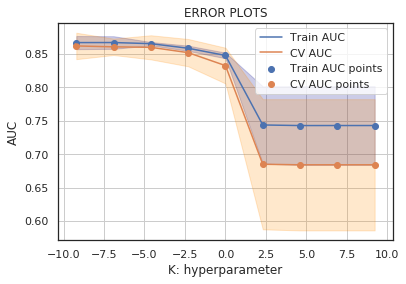

In [71]:

import math
logs = []
parameters = {'alpha':[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}
for i in parameters['alpha']:
    b = math.log(i)
    logs.append(b)

neigh = SGDClassifier(loss = 'hinge',penalty = 'l2',class_weight = 'balanced')



clf = GridSearchCV(neigh, parameters, cv=5, scoring='roc_auc',return_train_score=True)
#fit on train features and the classification target features.
clf.fit(features_train, target_2_train.values.ravel()) #change dim from (n) to (n,)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(logs, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(logs,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(logs, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(logs,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(logs, train_auc, label='Train AUC points')
plt.scatter(logs, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [72]:
#target_2_test = target_2_test.astype('int')

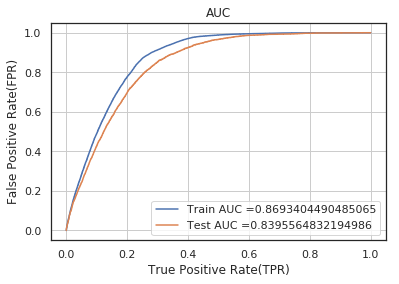

In [73]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.svm import SVC


neigh = SGDClassifier(loss = 'hinge', penalty= 'l2',alpha = 10**-4,class_weight='balanced')
neigh.fit(features_train, target_2_train.values.ravel())
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = neigh.decision_function(features_train)

y_test_pred = neigh.decision_function(features_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(target_2_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(target_2_test, y_test_pred)


plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

- We will now reshape the predicted values of the calssification model so that we can horizontally stack them with the features.

In [74]:
y_train_new = y_train_pred.reshape((target_2_train.shape[0],1))
y_new = y_test_pred.reshape((target_2_test.shape[0] ,1))

#### We will now stack the predicted classification values and build a regression model on top of this.

In [75]:
new_train = hstack((features_train,target_2_train))
new_test = hstack((features_test,y_new))

### Light GBM regression model

In [76]:
params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 70,
        "min_data_in_leaf":20,
        "max_depth":10
        
    }
    
    # convert our training data into LightGBM dataset format:
lgtrain = lgb.Dataset(new_train, label=target_train)
#lgval = lgb.Dataset(val_X, label=val_y)
model = lgb.train(params, lgtrain)
pred_test_y = model.predict(new_test)
rmse = np.sqrt(mean_squared_error(pred_test_y, target_test))
rmse

/home/mayankkhanna3340/.local/lib/python3.5/site-packages/lightgbm/basic.py:546: UserWarning:

Converting data to scipy sparse matrix.



9.486962476254506

In [77]:
rmse = np.sqrt(mean_squared_error(pred_test_y, target_test))
rmse

9.486962476254506

### XGBoost Regressor

In [78]:
x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=50,
 max_depth=6,
 min_child_weight=1,
 gamma=0,
 subsample=0.6,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)
x_model.fit(new_train, target_train)

[08:51:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
             reg_alpha=200, reg_lambda=200, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.6, verbosity=1)

In [79]:
y_pred = x_model.predict(new_test)

In [80]:
rmse = np.sqrt(mean_squared_error(y_pred, target_test))
rmse

8.980658270775246

# Conclusion

In [200]:
from prettytable import PrettyTable

In [282]:
x = PrettyTable()

x.field_names = ["Method", "RMSE"]

x.add_row(["Light GBM", 2.06])
x.add_row(["XGBoost", 1.98])
x.add_row(["Catboost",2.09])
x.add_row(["light gbm after classification", 9.97])
x.add_row(["XGboost after classification", 9.42])

print(x)

+--------------------------------+------+
|             Method             | RMSE |
+--------------------------------+------+
|           Light GBM            | 2.06 |
|            XGBoost             | 1.98 |
|            Catboost            | 2.09 |
| light gbm after classification | 9.97 |
|  XGboost after classification  | 9.42 |
+--------------------------------+------+


# Regression Models with XG Boost

- Our final approach to this problem consists of using regression techniques to get the predicted values on forward data, and then run a XGBoost model using the predicted values as features to the model.
- For this approach, we make an assumption that users who did not make a purchase are not likely to make one in the future either. Therefore, we just directly score them 0.

In [ ]:
#loading and concatenating train and test data. the date is cinverted to string and in a date format readable by python
df_train = pd.read_csv('train-flattened.csv')
df_test = pd.read_csv('test-flattened.csv')
df_train['date'] = df_train['date'].astype(str)
df_train["date"] = df_train["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
df_train["date"] = pd.to_datetime(df_train["date"])

df_test['date'] = df_test['date'].astype(str)
df_test["date"] = df_test["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
df_test["date"] = pd.to_datetime(df_test["date"])


df = pd.concat([df_train,df_test])

In [ ]:
df = df.fillna(0)
df['totals.totalTransactionRevenue'] = df['totals.totalTransactionRevenue'].fillna(0).astype(float)
# all unique users who visited the website
revenue_user = df.groupby('fullVisitorId')['totals.totalTransactionRevenue'].sum().reset_index()

In [ ]:
#unique users with positive revenue ~ 20724
users_pos = revenue_user[revenue_user['totals.totalTransactionRevenue']>0.0]

In [ ]:
# row enteries from the original dataframe where people made total positive revenue ~ 68046
df_users_pos = df[df['fullVisitorId'].isin(users_pos['fullVisitorId'])]

In [ ]:
#histogram of all the users' total transaction revenue where there was a positive revenue
# x - axis: Value of transactions
#y - axis : Total  number of users
np.log1p(users_pos['totals.totalTransactionRevenue']).hist(bins=10);

In [ ]:
# we find the revenue by date bu only users who have a positive revenue
# revenue by date
rev_by_date = df_users_pos.groupby('date')['totals.totalTransactionRevenue'].sum().reset_index()
plt.figure(figsize=(30,8))
plt.plot(rev_by_date['date'], rev_by_date['totals.totalTransactionRevenue']);

- Using FBProphet, we will take 4 features and then make a regression model using these 4 features

In [ ]:
# Preparing data frames
norm_pred = pd.DataFrame( {'ds':rev_by_date['date'].values,'y':rev_by_date['totals.totalTransactionRevenue'].values})
box_cox_pred = pd.DataFrame( {'ds':rev_by_date['date'].values,'y':rev_by_date['totals.totalTransactionRevenue'].values})
DXS = pd.DataFrame({'ds':rev_by_date['date'].values,'y':rev_by_date['totals.totalTransactionRevenue'].values})
TXS = pd.DataFrame({'ds':rev_by_date['date'].values,'y':rev_by_date['totals.totalTransactionRevenue'].values})

### Forward prediction on transaction revenues

In [ ]:
#https://towardsdatascience.com/forecasting-in-python-with-facebook-prophet-29810eb57e66
#https://facebook.github.io/prophet/docs/quick_start.html#python-api
#Uses an additive model and has particularly good performance for non linear data

In [ ]:
from fbprophet import Prophet
prophet = Prophet()
prophet.fit(norm_pred)
future = prophet.make_future_dataframe(periods=4*30, freq='D')
forecast_norm = prophet.predict(future)
fig = prophet.plot(forecast_norm)

### Box Cox Transform and prediction using FB Prophet

In [ ]:
#https://www.statisticshowto.datasciencecentral.com/box-cox-transformation/

- We will also use a box-cox transform. A box cox tranform transforms the data to a normal distributon. 
- It is generally seen that ML models work better with Normally distributed data
- We will then take the transformed data and run it through fbprophet to get the final values. 
- We will then take the inverse box cox on the predicted fbprophet vlues to get the data according to the original distribution.

In [ ]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox
box_arr,lamb = boxcox(box_cox_pred['y'].values + 1)

In [ ]:
del box_cox_pred['y']
box_cox_pred['y'] = box_arr

In [ ]:
prophet = Prophet()
prophet.fit(box_cox_pred)
future = prophet.make_future_dataframe(periods=4*30, freq='D')
forecast_box = prophet.predict(future)
fig = prophet.plot(forecast_box)

In [ ]:
forecast_box['yhat'] = inv_boxcox(forecast_box['yhat'], lamb)

### Double Exponential Smoothing and forward prediction using FB Prophet

One of the drawbacks of single exponential smothing is that it does not account for trends in the data. This can be improved by introducing an additional equation to account for trend in the data. Double Exponential Smoothing uses two equations to forecast the future values of time series data - one for forecasting the level and the other for forecasting the trend. 

In [ ]:
##https://grisha.org/blog/2016/02/17/triple-exponential-smoothing-forecasting-part-iii/

In [ ]:
#ℓx=αyx+(1−α)(ℓx−1+bx−1)level
#bx=β(ℓx−ℓx−1)+(1−β)bx−1trend
#y^x+1=ℓx+bxforecast
def double_exponential_smoothing(series,alpha,beta):
    result = [series[0]]
    for n in range(1,len(series)+1):
        if n == 1:
            level,trend = series[0],series[1]-series[0]
        if n >= len(series):
            value = result[-1]
        else:
            value = series[n]
        last_level,level = level,alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level)+(1-beta)*trend
        result.append(level+trend)
    return result

alpha = 0.2
beta = 0.15

DXS_pred = double_exponential_smoothing(DXS['y'].values, alpha, beta)

In [ ]:
del DXS['y']
DXS['y'] = DXS_pred[1:]

In [ ]:
prophet = Prophet()
prophet.fit(DXS)
future = prophet.make_future_dataframe(periods=4*30, freq='D')
forecast_DXS = prophet.predict(future)
fig = prophet.plot(forecast_DXS)

### Triple exponential Smoothing

If there is seasonality in the data, the techniques discussed so far may fall short. Triple exponential smoothing is used when the data has trend and seasonality. 

In [ ]:
#ℓx=α(yx−sx−L)+(1−α)(ℓx−1+bx−1) level
#bx=β(ℓx−ℓx−1)+(1−β)bx−1 Trend
#sx=γ(yx−ℓx)+(1−γ)sx−L seasonal
#y^x+m=ℓx+mbx+sx−L+1+(m−1) modL

def initial_trend(series,slen):
    s = 0.0
    for i in range(slen):
        s += float(series[i+slen]-series[i])/slen
    return s/slen

def initial_seasonal_components(series, slen):
    #Season length is the number of data points after which a new season begins. We will use L to denote season length.
    #The seasonal component is an additional deviation from level + trend that repeats itself at the same offset into the season.
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [ ]:
alpha = 0.2
beta = 0.15
gamma = 0.1
slen = 24
XS_pred = triple_exponential_smoothing(TXS['y'].values,slen, alpha, beta,gamma,1)

In [ ]:
del TXS['y']
TXS['y'] = XS_pred[1:]

In [ ]:
prophet = Prophet()
prophet.fit(TXS)
future = prophet.make_future_dataframe(periods=4*30, freq='D')
forecast_TXS = prophet.predict(future)
fig = prophet.plot(forecast_TXS)

### XGBoost Regression Modle

- We will now use the the forecasted values as features and apply regression models on it

In [ ]:
#preparing data for regression
forecast_norm.rename(columns = {'ds':'date'},inplace = True)
forecast_box.rename(columns = {'ds':'date'},inplace = True)
forecast_DXS.rename(columns = {'ds':'date'},inplace = True)
forecast_TXS.rename(columns = {'ds':'date'},inplace = True)


In [ ]:
#preparing data from regression
drop_list = ['date','yhat']
forecast_norm = forecast_norm.drop(forecast_norm.columns.difference(drop_list), axis=1)
forecast_box = forecast_box.drop(forecast_box.columns.difference(drop_list), axis=1)
forecast_DXS = forecast_DXS.drop(forecast_DXS.columns.difference(drop_list), axis=1)
forecast_TXS = forecast_TXS.drop(forecast_TXS.columns.difference(drop_list), axis=1)


In [ ]:
#prepareing data for regression
forecast_norm.rename(columns= {'yhat':'1'},inplace = True)
forecast_box.rename(columns= {'yhat':'2'},inplace = True)
forecast_DXS.rename(columns= {'yhat':'3'},inplace = True)
forecast_TXS.rename(columns= {'yhat':'4'},inplace = True)

In [ ]:
reg_data = pd.merge(rev_by_date,forecast_norm,on = 'date',how = 'left')
reg_data= pd.merge(reg_data,forecast_box,on = 'date',how = 'left')
reg_data= pd.merge(reg_data,forecast_DXS,on = 'date',how = 'left')
reg_data= pd.merge(reg_data,forecast_TXS,on = 'date',how = 'left')

In [ ]:
y = reg_data['totals.totalTransactionRevenue'].values
del reg_data['totals.totalTransactionRevenue']
del reg_data['date']

In [ ]:
X_train, X_test = np.split(reg_data, [int(.75 *len(reg_data))])
Y_train,Y_test = np.split(y, [int(.75 *len(y))])

## XGBoost on features

In [ ]:
regr2 = xgb.XGBRegressor(n_jobs=-1)
param_grid = {'max_depth':[2,3,4,5,6],'min_child_weight':[1,2,3,4,5,6],'subsample':[.4,.6,.8],'n_estimators':[50,100,300,500,1000]}
gs_xgb = RandomizedSearchCV(regr2,param_grid,scoring = 'neg_mean_squared_error')
gs_xgb.fit(X_train, Y_train)

In [ ]:
gs_xgb.best_params_

In [34]:
x_model = xgb.XGBRegressor(
 learning_rate =0.01,
 n_estimators=50,
 max_depth=2,
 min_child_weight=0.6,
 
 subsample=0.4,
 
 nthread=8)
x_model.fit(X_train, Y_train)

[01:26:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=2, min_child_weight=0.6, missing=None, n_estimators=50,
             n_jobs=1, nthread=8, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.4, verbosity=1)

In [35]:
pred_norm = forecast_norm.loc[(forecast_norm['date'] >= '2018-12-01')&(forecast_norm['date']<='2019-01-31')]
pred_box = forecast_box.loc[(forecast_box['date'] >= '2018-12-01')&(forecast_box['date']<='2019-01-31')]
pred_DXS = forecast_DXS.loc[(forecast_DXS['date'] >= '2018-12-01')&(forecast_DXS['date']<='2019-01-31')]
pred_TXS = forecast_TXS.loc[(forecast_TXS['date'] >= '2018-12-01')&(forecast_TXS['date']<='2019-01-31')]

In [36]:
from functools import reduce
dfs = [pred_norm, pred_box, pred_DXS, pred_TXS]
final_data = reduce(lambda left,right: pd.merge(left,right,on='date'), dfs)
del final_data['date']

In [37]:
y_pred = x_model.predict(final_data)

In [ ]:
pickle.dump(x_model, open("XGBoost-mod.pickle.dat", "wb"))

In [54]:
# we are seeing what ratio of the total transaction value of the whole dataset did a particular user contribute. 
distribution_by_visitor = (df.groupby('fullVisitorId')['totals.totalTransactionRevenue'].sum() / df.groupby('fullVisitorId')['totals.totalTransactionRevenue'].sum().sum())

In [55]:
distribution_by_visitor

fullVisitorId
259678714014           0.0
1995526696366          0.0
3038793126460          0.0
4823595352351          0.0
5103959234087          0.0
                      ... 
9999819762744314978    0.0
9999824326944242344    0.0
9999825631375939274    0.0
9999941518946450908    0.0
9999997304197521748    0.0
Name: totals.totalTransactionRevenue, Length: 1669227, dtype: float64

In [58]:
# sum of every transaction divided by the length of all users. This tells us on an aveage, how much to scale the outut by
scale = (df_users_pos['totals.totalTransactionRevenue'] > 0).sum() / len(df_users_pos)
# here we're scaling the prediction of the model by a scale that we set. We are saying that each user will buy proportionally more 
# as the value of the scale multiplied by the total sum of prediction and the value of what he bought earlier.
# as in, customer who spent more is spend more in this period as well.
distr_res = np.log1p(distribution_by_visitor * scale * y_pred.sum())

In [60]:
#Source : Kaggle 
sample = pd.read_csv('sample_submission_v2.csv', dtype={'fullVisitorId': 'str'}, )
solution = sample.merge(distr_res.reset_index(), on='fullVisitorId', how='left')
solution = (solution.drop('PredictedLogRevenue', axis=1).rename(columns={'totals.totalTransactionRevenue': 'PredictedLogRevenue'}))
solution['PredictedLogRevenue'].astype(float).fillna(0).reset_index()
solution.to_csv('sub.csv', index=False,na_rep = 0.0)

## Light GBM

In [62]:
#light GBM
param_grid = {
    'num_leaves': [10,30,50,70,90],
    'min_data_in_leaf': [1, 5, 10,20,30],
    'max_depth': [5,10,20, 30, 50],
    }

est = lgb.LGBMRegressor()
grid = GridSearchCV(est, param_grid,verbose=0,cv=4,n_jobs=-1)
grid.fit(X_train,Y_train)
print(grid.best_params_)
print(grid.best_score_)

{'min_data_in_leaf': 20, 'max_depth': 5, 'num_leaves': 10}
0.1657578962955516


In [ ]:
params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 10,
        "min_data_in_leaf":20,
        "max_depth":5
        
    }
    
    # convert our training data into LightGBM dataset format:
lgtrain = lgb.Dataset(X_train, label=Y_train)
#lgval = lgb.Dataset(val_X, label=val_y)
model = lgb.train(params, lgtrain)
pred_test_y = model.predict(reg_data)

## Catboost

In [ ]:
from catboost import CatBoostRegressor
model = CatBoostRegressor(
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.4,
                             od_type='Iter',
                             task_type="CPU")

model.fit(X_train, Y_train)


y_pred_test = model.predict(reg_data)


# Results

In [73]:
print ("(Tree Based Regression Methods) -       RMSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("XGBOOST                             : ",0.948)
print ("CAT Boost                           : ",0.986)
print ("Light GBM                           : ",0.983)


(Tree Based Regression Methods) -       RMSE
--------------------------------------------------------------------------------------------------------
XGBOOST                             :  0.948
CAT Boost                           :  0.986
Light GBM                           :  0.983
